# Libraries

In [23]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, mean_squared_error, make_scorer,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import re

from nltk import WordNetLemmatizer

import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')




[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Read Dataset

In [24]:
raw_df = pd.read_csv('train-balanced-sarcasm.csv')
raw_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# Data-preprocessing 

## Drop Features

Irrelevant: author, date, created_utc

In [32]:
# Drop NAs
raw_df.dropna(inplace=True)

# Select 100000 rows of sample
# Reset index so the cross validation later won't go wrong
filter_df = raw_df.sample(n=1000000, random_state=000).reset_index(drop=True)

# Drop irrelevant features
filter_df.drop(['author'],axis=1)

# Data is balance, do not need oversampling
print(filter_df['label'].value_counts()) 

# Show the data
filter_df.head()

0    500047
1    499953
Name: label, dtype: int64


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,"The title of this article should be: ""How to n...",xNOM,MensRights,1,1,0,2014-11,2014-11-07 11:48:34,You can approach women without being creepy
1,0,What a wasted opportunity... at least be funny...,Jacked1218,MMA,5,5,0,2016-07,2016-07-05 22:06:19,Nate Diaz Snapchat Hacked
2,1,But....but... sodium!,Chicup,fatlogic,1,1,0,2015-03,2015-03-09 13:16:40,Canned soups have been hugely helpful for the ...
3,1,"Yeah, we need more animosity between nations.",Bloodysneeze,worldnews,1,1,0,2013-07,2013-07-09 15:20:36,It really sounds like all the English speaking...
4,0,uuugh,name032282,Minecraft,2,2,0,2011-04,2011-04-02 04:50:42,Has anyone held a doggy funeral on their serve...


## Categorical Process

Comment Preprocess Functions

In [39]:

def preprocess_text(texts):
    """
    Preprocess a list of texts: lowercase, remove punctuation, and remove stopwords.
    """
    # Combine all texts into one large string
    combined_text = " ".join(texts)
    # Lowercase
    combined_text = combined_text.lower()
    # Remove punctuation
    combined_text = re.sub(r'[^\w\s]', '', combined_text)
    # Tokenize by splitting the text into words
    words = combined_text.split()
    # Remove stopwords
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return words

lemmatizer = WordNetLemmatizer()

def lemmatize_comment(comment):
    words = nltk.word_tokenize(comment)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)


def get_top_n_words(words, n=10):
    """
    Get the top n most common words from a list of words.
    """
    # Count words frequency
    word_counts = Counter(words)
    # Get the most common words
    common_words = word_counts.most_common(n)
    return common_words

Process comments

Categorize Comment with date

In [40]:
# Lemmatize Comments
# Don't want to lemmatize this because sometimes it eliminates the word I want
# filter_df['comments'] = filter_df['comment'].apply(lemmatize_comment)


# Convert 'created_utc' to datetime to extract the year
filter_df['created_utc'] = pd.to_datetime(filter_df['created_utc'])
filter_df['year'] = filter_df['created_utc'].dt.year

# Group data by year and filter out only sarcastic comments (label=1)
sarcastic_comments_by_year = filter_df[filter_df['label'] == 1].groupby('year')['comment'].apply(list)

sarcastic_comments_by_year


year
2009    [What an ergonomic position it generates on th...
2010    [Tax and spend "conservatives.", And this is e...
2011    [THANK YOU OBAMA, pervert, Yes, the only two o...
2012    [Your EDC?, But war means money., thats some s...
2013    [Yeah, we need more animosity between nations....
2014    [I can't believe Pak would just go around and ...
2015    [But....but... sodium!, Well that makes so muc...
2016    [Just imagine how great it will get when Trump...
Name: comment, dtype: object

In [73]:
words_2015 = preprocess_text(sarcastic_comments_by_year[2010])
top_words_2015 = get_top_n_words(words_2015, 5000)

words_to_extract_2009 = ['obama', 'man', 'white']

words_to_extract_2015 = ['gun', 'war', 'die', 'terrible', 'safe', 'shoot', 'terrorists', 'isis']

words_to_extract_2016 = ['trump','women','black','vote', 'win', 'government', 'president', 'clinton', 'racism','muslims','republicans','taxes']
extracted_data_2015 = [item for item in top_words_2015 if item[0] in words_to_extract_2015]

top_words_2015

[('yeah', 189),
 ('like', 157),
 ('just', 151),
 ('people', 150),
 ('dont', 135),
 ('yes', 120),
 ('im', 104),
 ('good', 96),
 ('know', 93),
 ('right', 93),
 ('thats', 92),
 ('sure', 83),
 ('god', 69),
 ('oh', 68),
 ('really', 68),
 ('think', 57),
 ('better', 55),
 ('way', 55),
 ('need', 54),
 ('time', 53),
 ('didnt', 53),
 ('government', 50),
 ('wow', 48),
 ('make', 48),
 ('obviously', 45),
 ('man', 43),
 ('thing', 42),
 ('want', 42),
 ('forgot', 41),
 ('going', 40),
 ('great', 40),
 ('free', 38),
 ('black', 38),
 ('reddit', 38),
 ('money', 38),
 ('youre', 38),
 ('isnt', 36),
 ('world', 35),
 ('hes', 35),
 ('did', 34),
 ('theyre', 34),
 ('stop', 33),
 ('arent', 33),
 ('thought', 32),
 ('bad', 32),
 ('mean', 32),
 ('look', 31),
 ('women', 31),
 ('clearly', 31),
 ('got', 31),
 ('totally', 31),
 ('doesnt', 30),
 ('years', 29),
 ('course', 29),
 ('hate', 28),
 ('love', 28),
 ('wrong', 28),
 ('real', 28),
 ('new', 27),
 ('hey', 27),
 ('maybe', 27),
 ('does', 27),
 ('yea', 27),
 ('work', 27

visualization

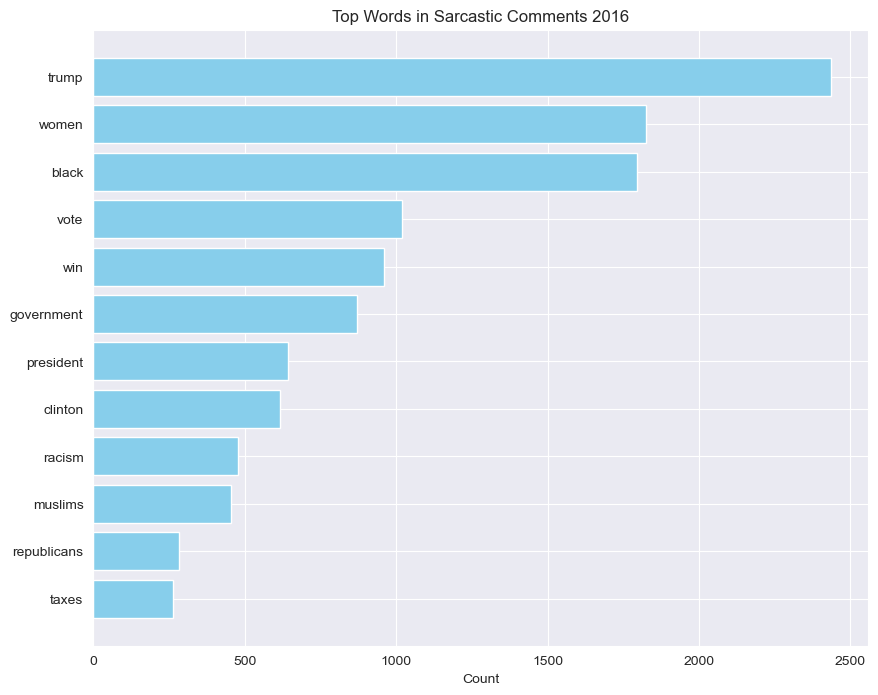

In [64]:
# Convert to DataFrame for easier plotting
df = pd.DataFrame(extracted_data_2016, columns=['Word', 'Count'])

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(df['Word'], df['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top Words in Sarcastic Comments 2016')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.show()